In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('nycflights13-1.csv')
df1 = pd.read_csv('nycflights14-1.csv')
df2 = pd.read_csv('nycflights15-1.csv')
df3 = pd.read_csv('nycflights16-1.csv')
df4 = pd.read_csv('nycflights17-1.csv')
flight_data = pd.concat([df, df1, df2, df3, df4], ignore_index=True)
flight_data.info()
flight_data = flight_data[~flight_data.applymap(lambda x: x == 'NA').any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590212 entries, 0 to 1590211
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   year            1590212 non-null  int64  
 1   month           1590212 non-null  int64  
 2   day             1590212 non-null  int64  
 3   dep_time        1546820 non-null  float64
 4   sched_dep_time  1590212 non-null  int64  
 5   dep_delay       1546816 non-null  float64
 6   arr_time        1544926 non-null  float64
 7   sched_arr_time  1590212 non-null  int64  
 8   arr_delay       1541209 non-null  float64
 9   carrier         1590212 non-null  object 
 10  flight          1590212 non-null  int64  
 11  tailnum         1580620 non-null  object 
 12  origin          1590212 non-null  object 
 13  dest            1590212 non-null  object 
 14  air_time        1541209 non-null  float64
 15  distance        1590212 non-null  int64  
 16  hour            1590212 non-null  in

/var/folders/29/59_04ypd5n144glcd8qwhc6w0000gn/T/ipykernel_77262/1445386327.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  flight_data = flight_data[~flight_data.applymap(lambda x: x == 'NA').any(axis=1)]


In [3]:
# Combining year, month, and day into a single date column
flight_data['date'] = pd.to_datetime(flight_data[['year', 'month', 'day']])
    

In [4]:
daily_flight_counts = flight_data.groupby('date').agg(
    flight_count=pd.NamedAgg(column="flight", aggfunc="count"),
    avg_dep_delay=pd.NamedAgg(column="dep_delay", aggfunc="mean"),
    avg_arr_delay=pd.NamedAgg(column="arr_delay", aggfunc="mean"),
    unique_carriers=pd.NamedAgg(column="carrier", aggfunc=lambda x: x.nunique()),
    avg_air_time=pd.NamedAgg(column="air_time", aggfunc="mean"),
    total_distance=pd.NamedAgg(column="distance", aggfunc="sum"),
    flight_diversity=pd.NamedAgg(column="flight", aggfunc=lambda x: x.nunique()),
    peak_departure_hour=pd.NamedAgg(column="hour", aggfunc=lambda x: x.value_counts().idxmax()),
)

# Interpolating null values in 'avg_arr_delay'
daily_flight_counts['avg_arr_delay'] = daily_flight_counts['avg_arr_delay'].interpolate(method='linear')
# Interpolating null values in 'avg_arr_delay'
daily_flight_counts['avg_air_time'] = daily_flight_counts['avg_air_time'].interpolate(method='linear')
daily_flight_counts.reset_index(inplace=True)

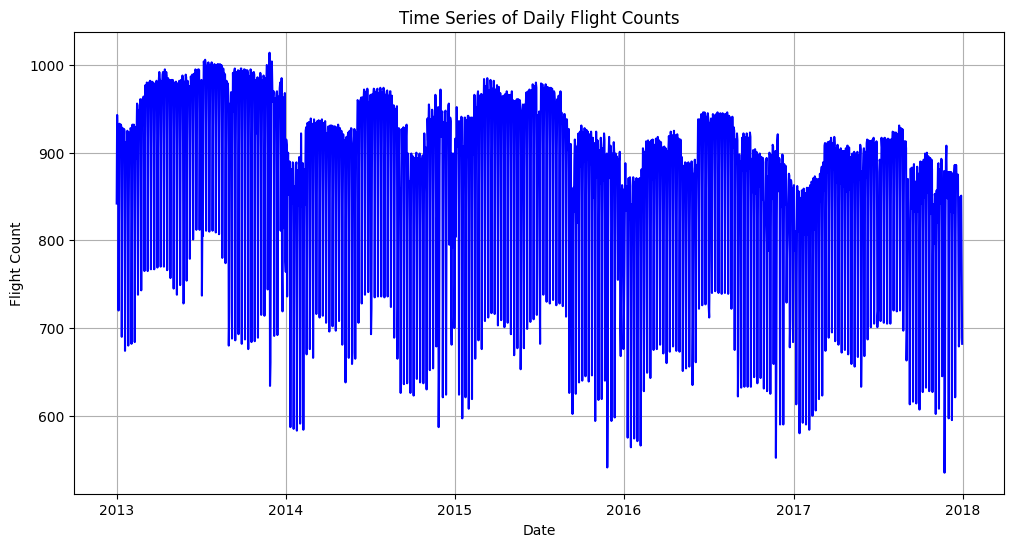

In [5]:
# Plot the time series of daily flight counts
plt.figure(figsize=(12, 6))
plt.plot(daily_flight_counts['date'], daily_flight_counts['flight_count'], linestyle='-', color='b')
plt.title('Time Series of Daily Flight Counts')
plt.xlabel('Date')
plt.ylabel('Flight Count')
plt.grid(True)
plt.show()

In [6]:
# Display the first few rows of the complete dataset
complete_flight_data = pd.DataFrame(daily_flight_counts)
complete_flight_data.head()

,date,flight_count,avg_dep_delay,avg_arr_delay,unique_carriers,avg_air_time,total_distance,flight_diversity,peak_departure_hour
0,2013-01-01,842,11.548926,12.651023,14,169.652226,907196,747,17
1,2013-01-02,943,13.858824,12.692888,14,162.198276,993090,837,6
2,2013-01-03,914,10.987832,5.733333,15,156.593333,948157,820,6
3,2013-01-04,915,8.951595,-1.932819,15,150.997797,944715,817,6
4,2013-01-05,720,5.732218,-1.525802,14,160.792190,768666,653,8


In [7]:
weather_data = pd.read_csv('weather.csv')

# Explore the first few rows and the data structure
weather_data_info = weather_data.info()
weather_data_head = weather_data.head()

# Convert the DATE column to datetime format
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

# Checking if the initial or final values in the 'TAVG' column are null
initial_nulls = weather_data['TAVG'].head().isnull().sum()
final_nulls = weather_data['TAVG'].tail().isnull().sum()

# Filling initial and final nulls with forward fill and backward fill respectively if needed
if initial_nulls > 0 or final_nulls > 0:
    weather_data['TAVG'] = weather_data['TAVG'].fillna(method='ffill').fillna(method='bfill')

# Reapplying linear interpolation
weather_data['TAVG'] = weather_data['TAVG'].interpolate(method='linear')

# Selecting only relevant columns for merging
weather_data_relevant = weather_data[['DATE', 'PRCP', 'SNOW', 'TAVG', 'TMAX', 'AWND','TMIN']]

# Merging the weather data with the complete flight data
complete_flight_weather_data = complete_flight_data.merge(weather_data_relevant, how='left', left_on='date', right_on='DATE')

# Dropping the extra DATE column from the weather dataset
complete_flight_weather_data.drop('DATE', axis=1, inplace=True)

# Display the first few rows of the merged dataset
complete_flight_weather_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 58 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          1826 non-null   object 
 1   NAME             1826 non-null   object 
 2   LATITUDE         1826 non-null   float64
 3   LONGITUDE        1826 non-null   float64
 4   ELEVATION        1826 non-null   float64
 5   DATE             1826 non-null   object 
 6   AWND             1826 non-null   float64
 7   AWND_ATTRIBUTES  1826 non-null   object 
 8   PGTM             1 non-null      float64
 9   PGTM_ATTRIBUTES  1 non-null      object 
 10  PRCP             1826 non-null   float64
 11  PRCP_ATTRIBUTES  1826 non-null   object 
 12  SNOW             1826 non-null   float64
 13  SNOW_ATTRIBUTES  1826 non-null   object 
 14  SNWD             1826 non-null   float64
 15  SNWD_ATTRIBUTES  1826 non-null   object 
 16  TAVG             1736 non-null   float64
 17  TAVG_ATTRIBUTE

/var/folders/29/59_04ypd5n144glcd8qwhc6w0000gn/T/ipykernel_77262/1697849315.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['TAVG'] = weather_data['TAVG'].fillna(method='ffill').fillna(method='bfill')


,date,flight_count,avg_dep_delay,avg_arr_delay,unique_carriers,avg_air_time,total_distance,flight_diversity,peak_departure_hour,PRCP,SNOW,TAVG,TMAX,AWND,TMIN
0,2013-01-01,842,11.548926,12.651023,14,169.652226,907196,747,17,0.0,0.0,49.0,41,15.21,27
1,2013-01-02,943,13.858824,12.692888,14,162.198276,993090,837,6,0.0,0.0,49.0,35,14.54,23
2,2013-01-03,914,10.987832,5.733333,15,156.593333,948157,820,6,0.0,0.0,49.0,33,11.63,25
3,2013-01-04,915,8.951595,-1.932819,15,150.997797,944715,817,6,0.0,0.0,49.0,39,16.33,30
4,2013-01-05,720,5.732218,-1.525802,14,160.792190,768666,653,8,0.0,0.0,49.0,45,11.63,32


In [8]:
holiday_data = pd.read_csv('holiday.csv')

# Convert the Date column to datetime format
holiday_data['Date'] = pd.to_datetime(holiday_data['Date'])

years = list(range(2013, 2018))  # This will create a list of years from 2013 to 2017
holiday_data_selected_years = holiday_data[holiday_data['Year'].isin(years)]

# Creating a new column to indicate if a date is a holiday (1 for holiday, 0 for non-holiday)
holiday_data_selected_years['IsHoliday'] = 1

# Selecting only relevant columns (Date and IsHoliday) for merging
holiday_data_relevant = holiday_data_selected_years[['Date', 'IsHoliday']]

# Merging the holiday data with the complete flight and weather data
complete_data_with_holidays = complete_flight_weather_data.merge(holiday_data_relevant, how='left', left_on='date', right_on='Date')

# Filling non-holiday dates with 0 (indicating not a holiday)
complete_data_with_holidays['IsHoliday'].fillna(0, inplace=True)

# Dropping the extra Date column from the holiday dataset
complete_data_with_holidays.drop('Date', axis=1, inplace=True)

# Convert IsHoliday to integer type
complete_data_with_holidays['IsHoliday'] = complete_data_with_holidays['IsHoliday'].astype(int)

# Display the first few rows of the merged dataset
complete_data_with_holidays.head()

/var/folders/29/59_04ypd5n144glcd8qwhc6w0000gn/T/ipykernel_77262/691731221.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holiday_data_selected_years['IsHoliday'] = 1


,date,flight_count,avg_dep_delay,avg_arr_delay,unique_carriers,avg_air_time,total_distance,flight_diversity,peak_departure_hour,PRCP,SNOW,TAVG,TMAX,AWND,TMIN,IsHoliday
0,2013-01-01,842,11.548926,12.651023,14,169.652226,907196,747,17,0.0,0.0,49.0,41,15.21,27,1
1,2013-01-02,943,13.858824,12.692888,14,162.198276,993090,837,6,0.0,0.0,49.0,35,14.54,23,0
2,2013-01-03,914,10.987832,5.733333,15,156.593333,948157,820,6,0.0,0.0,49.0,33,11.63,25,0
3,2013-01-04,915,8.951595,-1.932819,15,150.997797,944715,817,6,0.0,0.0,49.0,39,16.33,30,0
4,2013-01-05,720,5.732218,-1.525802,14,160.792190,768666,653,8,0.0,0.0,49.0,45,11.63,32,0


In [9]:
complete_data_with_holidays['date'] = pd.to_datetime(complete_data_with_holidays['date'])

#df_2013 = df[df['date'].dt.year == 2013]
# Filter the DataFrame for the year 2013
testing_df = complete_data_with_holidays[complete_data_with_holidays['date'].dt.year == 2013]
training_df = complete_data_with_holidays[complete_data_with_holidays['date'].dt.year != 2013]

print(len(training_df))
print(len(testing_df))

1463
365


/Users/tylergraham/Desktop/CS5610/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tylergraham/Desktop/CS5610/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tylergraham/Desktop/CS5610/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tylergraham/Desktop/CS5610/csc5610/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

(550.0, 1000.0)

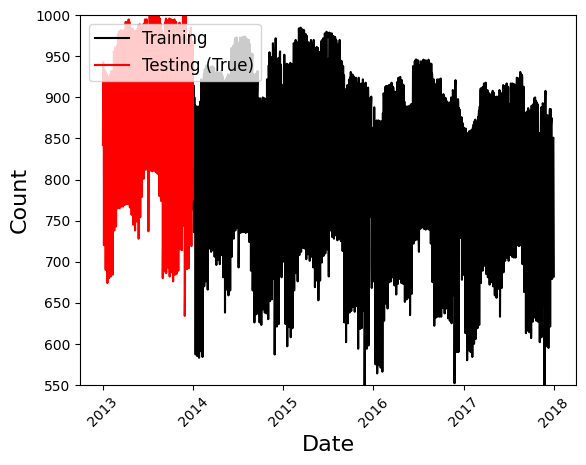

In [10]:
ax = sns.lineplot(data=training_df, x="date", y="flight_count", label="Training", color="black")
ax = sns.lineplot(data=testing_df, x="date", y="flight_count", label="Testing (True)", color="red")
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend(loc="upper left", fontsize=12)
plt.ylim([550, 1000])

In [11]:
# Find the timestamp of the first record
first_record_timestamp = complete_data_with_holidays['date'].min()

# Calculate the number of days elapsed from the first record
complete_data_with_holidays['days_elapsed'] = (complete_data_with_holidays['date'] - first_record_timestamp).dt.days


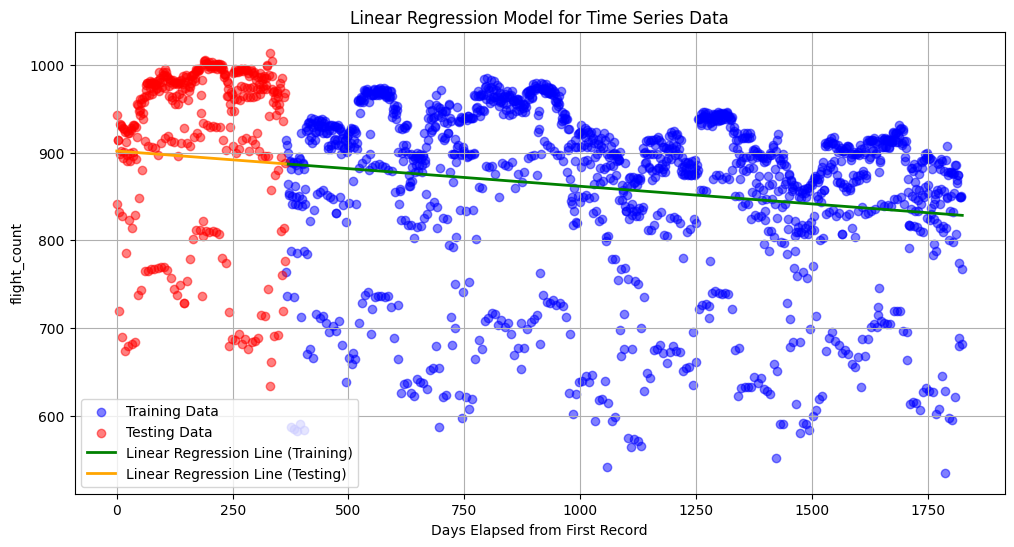

R-squared value: 0.0304
P-value: 1.8751456860472884e-11


In [12]:
# Assuming 'days_elapsed' is the independent variable and 'flight_count' is the dependent variable
X = complete_data_with_holidays['days_elapsed']
y = complete_data_with_holidays['flight_count']

testing_df = complete_data_with_holidays[complete_data_with_holidays['date'].dt.year == 2013]
training_df = complete_data_with_holidays[complete_data_with_holidays['date'].dt.year != 2013]

X_train = training_df['days_elapsed']
X_test = testing_df['days_elapsed']

y_train = training_df['flight_count']
y_test = testing_df['flight_count']

# Fit a simple linear regression model using SciPy
slope, intercept, r_value, p_value, std_err = stats.linregress(X_train, y_train)

# Create a regression line equation
regression_line_train = slope * X_train + intercept
regression_line_test = slope * X_test + intercept

# Plot the time series data and the regression lines
plt.figure(figsize=(12, 6))
plt.scatter(X_train, y_train, label='Training Data', color='blue', alpha=0.5)
plt.scatter(X_test, y_test, label='Testing Data', color='red', alpha=0.5)
plt.plot(X_train, regression_line_train, label='Linear Regression Line (Training)', color='green', linewidth=2)
plt.plot(X_test, regression_line_test, label='Linear Regression Line (Testing)', color='orange', linewidth=2)

plt.xlabel('Days Elapsed from First Record')
plt.ylabel('flight_count')
plt.legend()
plt.title('Linear Regression Model for Time Series Data')
plt.grid(True)
plt.show()

# Interpret the result of the associated statistical test
print(f"R-squared value: {r_value**2:.4f}")
print(f"P-value: {p_value}")

Mean Absolute Percentage Error (MAPE): 9.40%
Root Mean Squared Error (RMSE): 95.56


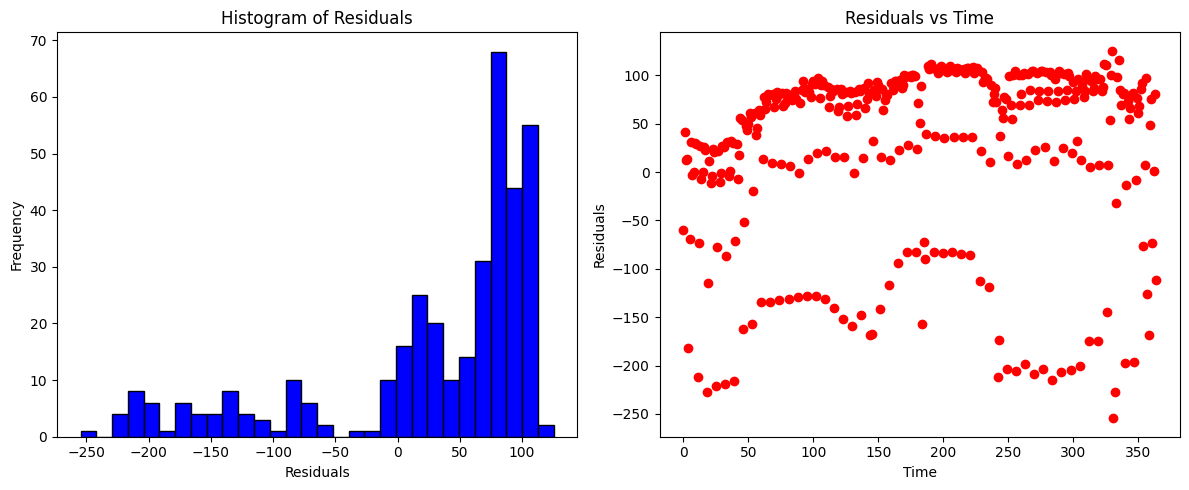

In [13]:
# Make predictions on the test data
y_pred = slope * X_test + intercept

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculating residuals for the test set
residuals = y_test - y_pred

# Plotting the histogram of residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Plotting residuals against time (using the index of the testing DataFrame)
plt.subplot(1, 2, 2)
plt.scatter(testing_df.index, residuals, color='red')
plt.title('Residuals vs Time')
plt.xlabel('Time')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


In [14]:
complete_data_with_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1828 non-null   datetime64[ns]
 1   flight_count         1828 non-null   int64         
 2   avg_dep_delay        1828 non-null   float64       
 3   avg_arr_delay        1828 non-null   float64       
 4   unique_carriers      1828 non-null   int64         
 5   avg_air_time         1828 non-null   float64       
 6   total_distance       1828 non-null   int64         
 7   flight_diversity     1828 non-null   int64         
 8   peak_departure_hour  1828 non-null   int64         
 9   PRCP                 1828 non-null   float64       
 10  SNOW                 1828 non-null   float64       
 11  TAVG                 1828 non-null   float64       
 12  TMAX                 1828 non-null   int64         
 13  AWND                 1828 non-nul

In [15]:
# Identifying categorical variables
categorical_vars = ['IsHoliday']

# Convert these variables to 'category' dtype
for var in categorical_vars:
    complete_data_with_holidays[var] = complete_data_with_holidays[var].astype('category')

# Generating dummy variables
df_dummies = pd.get_dummies(complete_data_with_holidays, columns=categorical_vars)
df_dummies.info()
df_dummies.to_csv("data3.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1828 non-null   datetime64[ns]
 1   flight_count         1828 non-null   int64         
 2   avg_dep_delay        1828 non-null   float64       
 3   avg_arr_delay        1828 non-null   float64       
 4   unique_carriers      1828 non-null   int64         
 5   avg_air_time         1828 non-null   float64       
 6   total_distance       1828 non-null   int64         
 7   flight_diversity     1828 non-null   int64         
 8   peak_departure_hour  1828 non-null   int64         
 9   PRCP                 1828 non-null   float64       
 10  SNOW                 1828 non-null   float64       
 11  TAVG                 1828 non-null   float64       
 12  TMAX                 1828 non-null   int64         
 13  AWND                 1828 non-nul

In [16]:
# Target variable
target = 'flight_count'

# Features: excluding the target and other non-relevant columns
features = df_dummies.columns.drop([target, 'date'])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_dummies[features], df_dummies[target], test_size=0.2, random_state=0)

# Creating and fitting the Ridge regression model with L2 regularization
# and positive coefficients constraint
ridge_model = Ridge(alpha=1.0, positive=True)
ridge_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = ridge_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)

1487.387183539222


In [17]:
# Calculating Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)

# Calculating Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(rmse)
print(mape)

38.56665896262239
3.5046982172001737


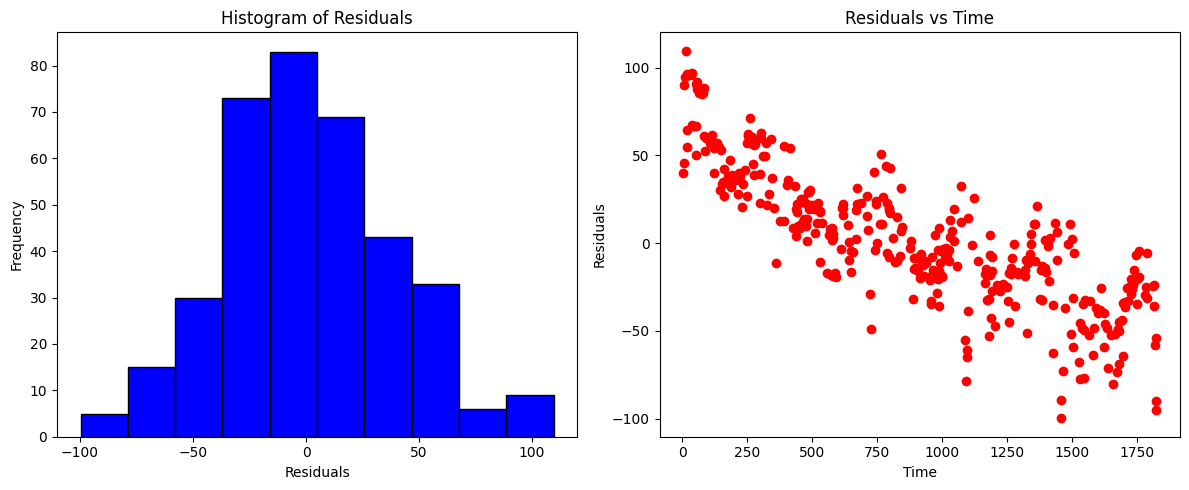

In [18]:
# Calculating residuals
residuals = y_test - y_pred

# Plotting the histogram of residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Plotting residuals against time
plt.subplot(1, 2, 2)
plt.scatter(X_test.index, residuals, color='red')
plt.title('Residuals vs Time')
plt.xlabel('Time')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

In [19]:
# Creating and fitting the Random Forest model
random_forest_model = RandomForestRegressor(random_state=0)
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculating MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Displaying the results
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape, "%")


Root Mean Squared Error: 5.355794191412233
Mean Absolute Percentage Error: 0.4654801152749746 %


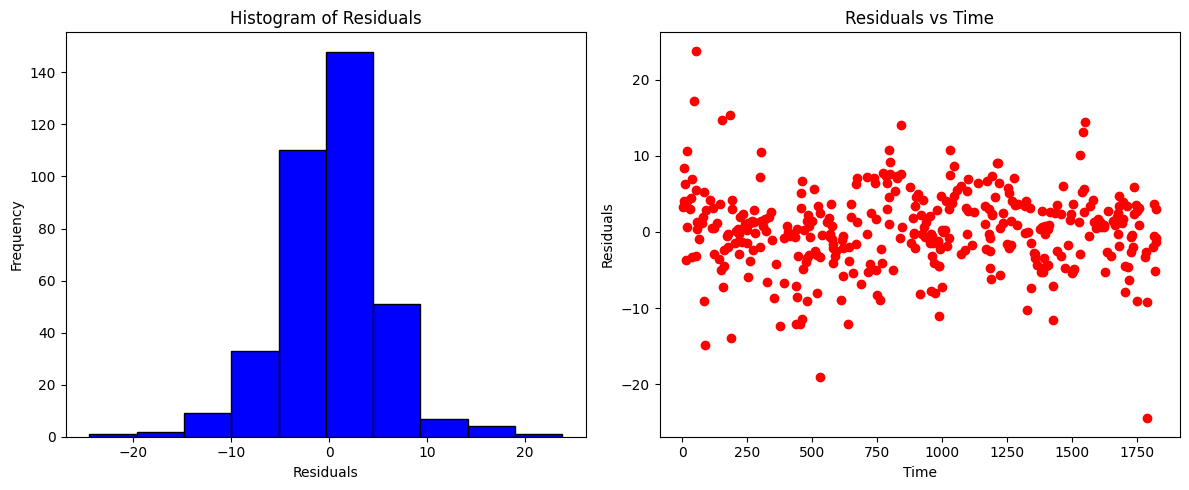

In [20]:
# Calculating residuals
residuals = y_test - y_pred

# Plotting the histogram of residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Plotting residuals against time
plt.subplot(1, 2, 2)
plt.scatter(X_test.index, residuals, color='red')
plt.title('Residuals vs Time')
plt.xlabel('Time')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

In [21]:

# Getting feature importances from Random Forest model
rf_feature_importances = random_forest_model.feature_importances_

# Creating a Series for better visualization
rf_feature_importances_series = pd.Series(rf_feature_importances, index=X_train.columns)

# Sorting the features by their importance
sorted_rf_features = rf_feature_importances_series.sort_values(ascending=False)

# Getting the 10 features with the largest importance scores from Random Forest model
top_10_rf_features = sorted_rf_features.head(10)

# Getting the coefficients from the Ridge model
ridge_coefficients = pd.Series(ridge_model.coef_, index=X_train.columns)

# Sorting the coefficients in descending order of their absolute values
sorted_ridge_coefficients = ridge_coefficients.abs().sort_values(ascending=False)

# Getting the 10 features with the largest coefficients in the Ridge model
top_10_ridge_features = sorted_ridge_coefficients.head(10)
print(top_10_ridge_features)
print(top_10_rf_features)

total_distance      1.002896e-03
flight_diversity    1.292115e-06
avg_arr_delay       4.181870e-08
TAVG                1.266093e-08
avg_dep_delay       1.141878e-08
unique_carriers     1.006770e-08
TMAX                3.353133e-09
AWND                1.917258e-09
IsHoliday_0         4.916971e-10
SNOW                7.604321e-11
dtype: float64
flight_diversity       0.992920
total_distance         0.002589
days_elapsed           0.002106
peak_departure_hour    0.000306
avg_dep_delay          0.000303
avg_air_time           0.000292
AWND                   0.000259
TMIN                   0.000256
TMAX                   0.000248
avg_arr_delay          0.000247
dtype: float64


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37184D+00    |proj g|=  1.08722D-01



/Users/tylergraham/Desktop/CS5610/csc5610/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tylergraham/Desktop/CS5610/csc5610/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate    5    f=  5.29133D+00    |proj g|=  1.41958D-02

At iterate   10    f=  5.23520D+00    |proj g|=  4.33545D-02

At iterate   15    f=  5.21222D+00    |proj g|=  4.56389D-05

At iterate   20    f=  5.21220D+00    |proj g|=  1.25192D-03

At iterate   25    f=  5.21200D+00    |proj g|=  8.70176D-04

At iterate   30    f=  5.21198D+00    |proj g|=  7.54119D-04

At iterate   35    f=  5.21197D+00    |proj g|=  1.51105D-04

At iterate   40    f=  5.21197D+00    |proj g|=  3.48258D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     58      1     0     0   2.965D-05   5.212D+00
  F =   5.211971963485

/Users/tylergraham/Desktop/CS5610/csc5610/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tylergraham/Desktop/CS5610/csc5610/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


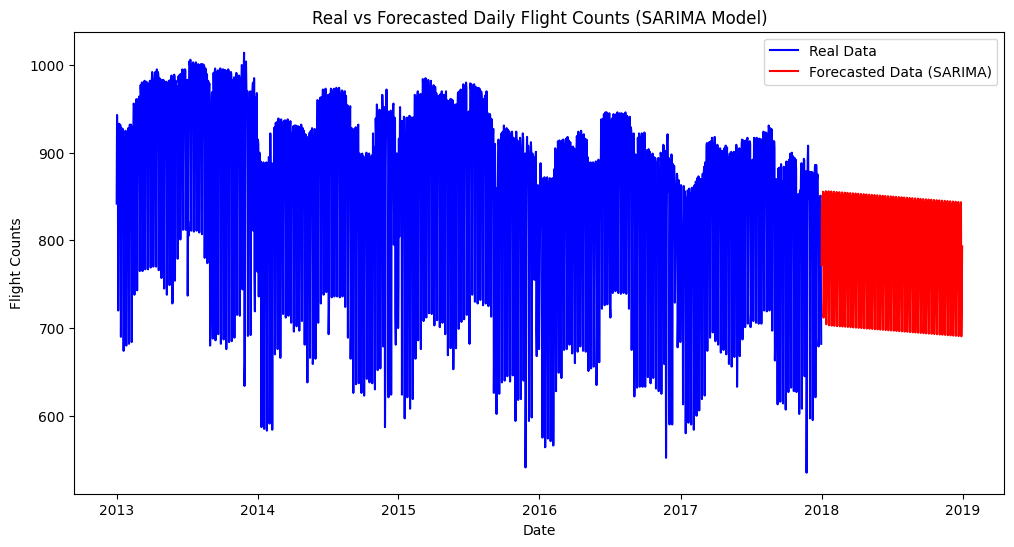

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set 'date' as the index of the DataFrame
complete_data_with_holidays.set_index('date', inplace=True)

# Separate the target variable and the exogenous variables
flight_count_series = complete_data_with_holidays['flight_count']

# Setting initial SARIMA parameters
# These are arbitrary and might need tuning for better results
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 7  # Seasonal parameters (weekly seasonality)

# Fit a SARIMA model
sarima_model = SARIMAX(flight_count_series, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit()
forecast_dates_2018 = pd.date_range(start='2018-01-01', end='2018-12-31')

# Forecasting for 2018
sarima_forecast_2018 = sarima_model_fit.forecast(steps=365)

# Plotting the real data and the SARIMA forecasted data
plt.figure(figsize=(12, 6))
plt.plot(flight_count_series.index, flight_count_series, label='Real Data', color='blue')
plt.plot(forecast_dates_2018, sarima_forecast_2018, label='Forecasted Data (SARIMA)', color='red')
plt.title('Real vs Forecasted Daily Flight Counts (SARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Flight Counts')
plt.legend()
plt.show()
